In [1]:
# Add the path of the beer source code ot the PYTHONPATH.
from collections import defaultdict
import random
import sys
sys.path.insert(0, '../')

import copy

import beer
import numpy as np
import torch

# For plotting.
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, gridplot
from bokeh.models import LinearAxis, Range1d
output_notebook()

# Convenience functions for plotting.
import plotting

%load_ext autoreload
%autoreload 2

Loading BokehJS ...

In [2]:
nsamples = 600
ndim = 2
nstates = 3
trans_mat = np.array([[.5, .5, 0], [0, .5, .5], [.5, 0, .5]])

means = [np.array([-1.5, 4]) * 2,np.array([5, 5]) * 2, np.array([1, -2])] * 2
covs = [np.array([[.75, -.5], [-.5, 2.]]), np.array([[2, 1], [1, .75]]), np.array([[1, 0], [0, 1]]) ]
normal_sets = [[means[0], covs[0]], [means[1], covs[1]], [means[2], covs[2]]] 

states = np.zeros(nsamples, dtype=int)
data = np.zeros((nsamples, ndim))
states[0] = 0
data[0] = np.random.multivariate_normal(means[states[0]], covs[states[0]], size=1)

colors = ['blue', 'red', 'green']
fig1 = figure(title='Samples', width=400, height=400)
fig1.circle(data[0, 0], data[0, 1], color=colors[states[0]])


for n in range(1, nsamples):
    states[n] = np.random.choice(np.arange(nstates), p=trans_mat[states[n-1]])
    data[n] = np.random.multivariate_normal(means[states[n]], covs[states[n]], size=1)
    fig1.circle(data[n, 0], data[n, 1], color=colors[states[n]], line_width=1)
    fig1.line(data[n-1:n+1, 0], data[n-1:n+1, 1], color='black', line_width=.5, alpha=.5)

fig2 = figure(title='Emissions',  width=400, height=400)
colors = ['blue', 'red', 'green']
for i, n in enumerate(normal_sets):
    plotting.plot_normal(fig2, n[0], n[1], alpha=.3, color=colors[i])
grid = gridplot([[fig1, fig2]])
show(grid)

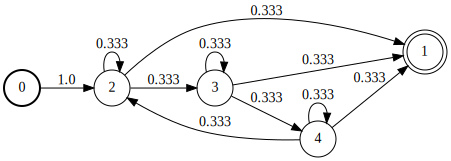

In [3]:
graph = beer.graph.Graph()

# Initial and final state are non-emitting.
s0 = graph.add_state()
s4 = graph.add_state()
graph.start_state = s0
graph.end_state = s4

s1 = graph.add_state(pdf_id=0)
s2 = graph.add_state(pdf_id=1)
s3 = graph.add_state(pdf_id=2)
graph.add_arc(s0, s1)
graph.add_arc(s1, s1)
graph.add_arc(s1, s2)
graph.add_arc(s2, s2)
graph.add_arc(s2, s3)
graph.add_arc(s3, s3)
graph.add_arc(s3, s1)
graph.add_arc(s1, s4)
graph.add_arc(s2, s4)
graph.add_arc(s3, s4)

graph.normalize()
graph

In [4]:
cgraph = graph.compile()
cgraph.final_log_probs

tensor([-1.0986, -1.0986, -1.0986])

In [5]:
# We use the global mean/cov. matrix of the data to initialize the mixture.
data_mean = torch.from_numpy(data.mean(axis=0)).float()
data_var = torch.from_numpy(np.cov(data.T)).float()

init_states = torch.LongTensor([0])
final_states = torch.LongTensor([2])
transitions = torch.from_numpy(trans_mat).float()

# HMM (full cov).
modelset = beer.NormalSet.create(data_mean, data_var, size=len(transitions),
                                prior_strength=1., noise_std=0, 
                                cov_type='full')
hmm_full = beer.HMM.create(cgraph, modelset)


models = {
    'hmm_full': hmm_full.double()
}

print(hmm_full) 

HMM(
  (modelset): DynamicallyOrderedModelSet(
    (original_modelset): NormalSet(
      (means_precisions): ConjugateBayesianParameter(prior=NormalWishart, posterior=NormalWishart)
    )
  )
  (graph): <CompiledGraph>
)


In [6]:
epochs = 30
lrate = 1.
X = torch.from_numpy(data)

optims = {
    model_name: beer.VBConjugateOptimizer(model.mean_field_factorization(), lrate)
    for model_name, model in models.items()
}

elbos = {
    model_name: [] 
    for model_name in models
}  

for epoch in range(epochs):
    for name, model in models.items():
        optim = optims[name]
        optim.init_step()
        elbo = beer.evidence_lower_bound(model, X, datasize=len(X), viterbi=False)
        elbo.backward()
        elbos[name].append(float(elbo) / len(X)) 
        optim.step()

In [7]:
fig = figure()
fig.line(range(len(elbos['hmm_full'])), elbos['hmm_full'])
show(fig)

In [8]:
encoder = beer.nnet.ResidualFeedForwardNet(dim_in=2, nblocks=2, block_width=2).double()
decoder = beer.nnet.ResidualFeedForwardNet(dim_in=2, nblocks=2, block_width=2).double()
vae = beer.VAE(hmm_full, encoder, decoder).double()

In [9]:
# small number of epochs for testing
epochs = 300
update_prior_after_epoch = 10
prior_lrate = 1.
cjg_optim = beer.VBConjugateOptimizer(vae.mean_field_factorization(), lrate=0)
std_optim = torch.optim.Adam(vae.parameters(), lr=1e-3)
optim = beer.VBOptimizer(cjg_optim, std_optim)

In [10]:
elbos = []
for e in range(epochs):
    optim.init_step()
    elbo = beer.evidence_lower_bound(vae, X, nsamples=5)
    elbo.backward()
    optim.step()
    
    if e >= update_prior_after_epoch:
        cjg_optim.lrate = prior_lrate
    elbos.append(float(elbo) / len(X))
    
fig = figure()
fig.line(range(len(elbos)), elbos)
show(fig)

In [11]:
elbos[-1]

-235311.61634792332